# Business Understanding
Die automatische Vorhersage von demografischen Merkmalen anhand von Gesichtern hat praktische Relevanz in verschiedenen Branchen: im Marketing & Retail mit dem Nutzen einer Zielgruppenanalyse für personalisierte Inhalte (z. B. Werbung, Produktempfehlungen), in Sicherheitssystemen zur Gesichtsanalyse für Zugangskontrollen oder demografisches Screening oder in der Sozialforschung für demografische Auswertung großer Bilddatensätze zur Analyse gesellschaftlicher Trends.

Das Ziel dieses Projekts ist die Entwicklung eines neuronalen Netzwerks zur automatisierten Gesichtsanalyse, das auf Basis eines Gesichtsfotos folgende drei demografische Merkmale gleichzeitig vorhersagt:
*   Alter (age)
*   Geschlecht (gender)
*   Ethnische Zugehörigkeit


# Data Understanding

In [56]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

In [57]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nipunarora8/age-gender-and-ethnicity-face-data-csv")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv/versions/1


In [58]:
csv_file = os.path.join(path, "age_gender.csv")
data = pd.read_csv(csv_file)
data = data.drop("img_name", axis = 1)

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))


In [59]:
# First look an data
print('Total rows: {}'.format(len(data)))
data.isnull().sum()
data.head()

Total rows: 23705


,age,ethnicity,gender,pixels
0,1,2,0,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


## Distributions

In [60]:
## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def distribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()


In [61]:
distribution_plot(age_dist.index,age_dist.values,'Age Distribution')

In [62]:
distribution_plot(ethnicity_dist.index,ethnicity_dist.values,'Ethnicity Distribution')

In [63]:
distribution_plot(gender_dist.index,gender_dist.values,'Gender Distribution')

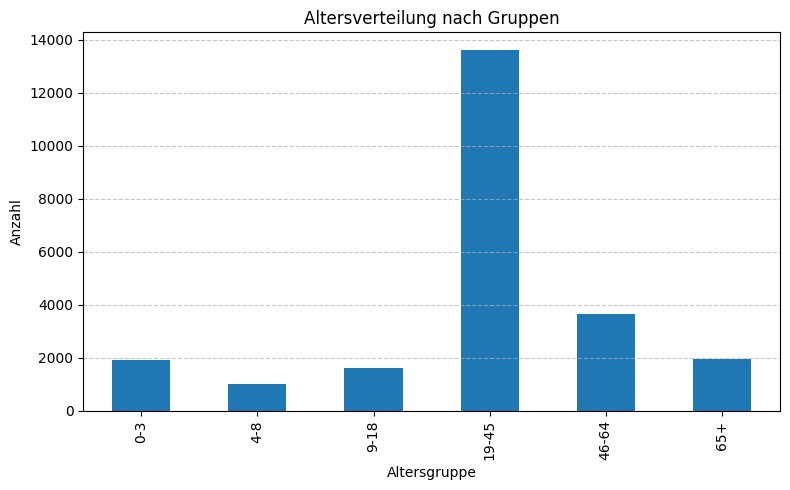

In [64]:
# Altersgruppen definieren (Bins)
bins = [0, 3, 8, 18, 45, 64, 116]
labels = ['0-3', '4-8', '9-18', '19-45', '46-64', '65+']

# Altersgruppen als neue Spalte hinzufügen
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

# Häufigkeiten je Altersgruppe berechnen
age_group_counts = data['age_group'].value_counts().sort_index()

# Balkendiagramm erstellen
plt.figure(figsize=(8, 5))
age_group_counts.plot(kind='bar')
plt.title('Altersverteilung nach Gruppen')
plt.xlabel('Altersgruppe')
plt.ylabel('Anzahl')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Shape of Images

In [65]:
first_image_array = data['pixels'].iloc[0]
image_size = int(np.sqrt(len(first_image_array)))
print(f"Das Bild hat die Maße: {image_size}x{image_size}")

pixel_lengths = data['pixels'].apply(len)
unique_lengths = pixel_lengths.unique()

print("Verschiedene Bildgrößen (Anzahl Pixel):", unique_lengths)

Das Bild hat die Maße: 48x48
Verschiedene Bildgrößen (Anzahl Pixel): [2304]


## Normalize and Reshape Data

In [66]:
## normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

In [67]:
# Alle Bilder in 48x48 umformen (für Graustufenbilder ohne Kanal-Dimension)
images = np.stack(data['pixels'].apply(lambda x: x.reshape(48, 48)))
print("Bilderform:", images.shape)

# Optional (falls du Kanal-Dimension brauchst, z. B. für CNN-Eingabe):
images = images.reshape(-1, 48, 48, 1)
print("Bilderform nach Kanal-Dimension:", images.shape)

Bilderform: (23705, 48, 48)
Bilderform nach Kanal-Dimension: (23705, 48, 48, 1)


## Image Overview

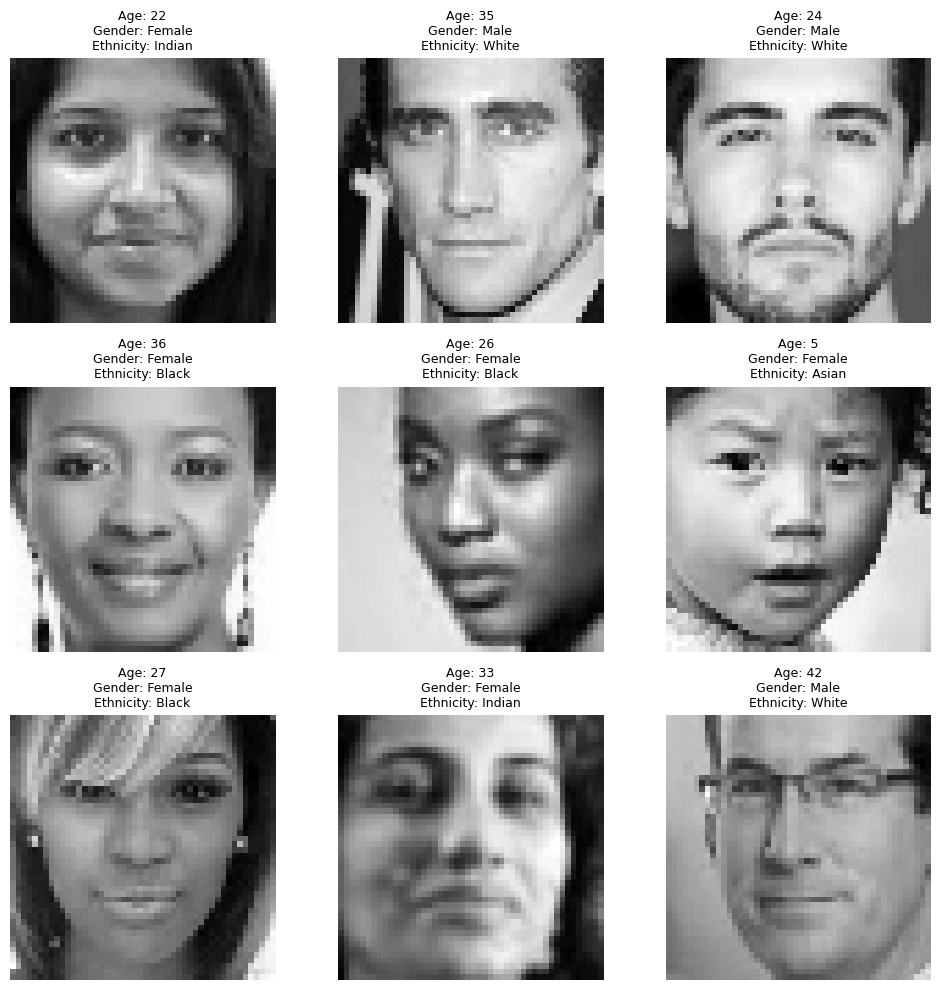

In [68]:
# Zufällig 9 Bilder auswählen
random_indices = np.random.choice(len(data), size=9, replace=False)
selected_images = images[random_indices]
selected_rows = data.iloc[random_indices]

# Mapping für Gender und Ethnicity (optional anpassbar)
gender_map = {0: "Male", 1: "Female"}
ethnicity_map = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Other"
}

# Galerie anzeigen
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(selected_images[i], cmap='gray')

    age = selected_rows.iloc[i]['age']
    gender = gender_map.get(selected_rows.iloc[i]['gender'], "Unknown")
    ethnicity = ethnicity_map.get(selected_rows.iloc[i]['ethnicity'], "Unknown")

    plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Data Preperation

In [69]:
# Features (X): die Bilder
X = images

# Targets (Y): die 3 Spalten
y_age = data['age'].astype(int)
y_gender = data['gender'].astype(int)
y_ethnicity = data['ethnicity'].astype(int)


In [70]:
from sklearn.preprocessing import LabelEncoder

# Alter als Klasse (z. B. Klasse 0 bis max age)
max_age = data['age'].max()
age_labels = data['age'].astype(int)

# Gender und Ethnicity bleiben wie sie sind (0/1 bzw. 0–4)
gender_labels = data['gender'].astype(int)
ethnicity_labels = data['ethnicity'].astype(int)

## Test-Train-Split

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_ethnicity, test_size=0.3, random_state=42)

In [72]:
# Korrektur der Unbalanciertheit für das Training durch Gewichtungen

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# y_train = Integer-Klassen (z. B. 0–4)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# In dict umwandeln
class_weight_dict = dict(enumerate(class_weights))


In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator mit Augmentierungen
datagen = ImageDataGenerator(
    rotation_range=5,          # max. ±5° Drehung
    zoom_range=0.1,            # bis zu ±10% Zoom
    width_shift_range=0.1,     # bis zu ±10% horizontale Verschiebung
    height_shift_range=0.1,    # bis zu ±10% vertikale Verschiebung
    shear_range=0.05,          # leichte Scherung (optional)
    horizontal_flip=True,      # Spiegelung aktivieren
    fill_mode='nearest'        # leere Pixel füllen
)

#train_generator = datagen.flow(X_train, y_train, batch_size=64)

# Modeling

In [74]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def define_model(activation='relu', loss='sparse_categorical_crossentropy', num_classes=5):
    input_layer = Input(shape=(48, 48, 1))

    # Block 1
    x = layers.Conv2D(32, (3, 3), activation=activation, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation=activation, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), activation=activation, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Dense Block
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation=activation)(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    output = layers.Dense(num_classes, activation='softmax')(x)

    # Modell definieren
    model = models.Model(inputs=input_layer, outputs=output)

    # Modell kompilieren
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=['accuracy']
    )

    return model


In [75]:
model = define_model()

In [76]:
"""model.compile(
    optimizer='adam',
    loss={
        'age': 'sparse_categorical_crossentropy',
        'gender': 'binary_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    metrics={
        'age': ['accuracy', tf.keras.metrics.MeanAbsoluteError()],
        'gender': ['accuracy'],
        'ethnicity': ['accuracy']
    }
)
"""

"model.compile(\n    optimizer='adam',\n    loss={\n        'age': 'sparse_categorical_crossentropy',\n        'gender': 'binary_crossentropy',\n        'ethnicity': 'sparse_categorical_crossentropy'\n    },\n    metrics={\n        'age': ['accuracy', tf.keras.metrics.MeanAbsoluteError()],\n        'gender': ['accuracy'],\n        'ethnicity': ['accuracy']\n    }\n)\n"

In [77]:
import tensorflow as tf

class EarlyStoppingByAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.70):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None and val_acc >= self.threshold:
            print(f"\nValidation accuracy reached {val_acc:.2%} (threshold: {self.threshold:.2%}). Stopping training.")
            self.model.stop_training = True

early_stop_test = EarlyStoppingByAccuracy(threshold=0.80)

In [78]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,              # Stoppt nach 3 Epochen ohne Verbesserung
    restore_best_weights=True
)


In [79]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,              # Lernrate wird halbiert
    patience=2,              # nach 2 Epochen ohne Verbesserung
    min_lr=1e-5              # unter diese Grenze geht sie nicht
)


In [80]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,274,757 (4.86 MB)

 Trainable params: 1,274,309 (4.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [81]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop_test, lr_scheduler]
)

"""
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 64,
    validation_data=(X_test, y_test),
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=[early_stop_test, lr_scheduler]
)"""

Epoch 1/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 122s 457ms/step - accuracy: 0.3490 - loss: 2.1779 - val_accuracy: 0.4537 - val_loss: 2.1415 - learning_rate: 0.0010
Epoch 2/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 142s 458ms/step - accuracy: 0.5587 - loss: 1.1860 - val_accuracy: 0.6091 - val_loss: 1.0368 - learning_rate: 0.0010
Epoch 3/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 151s 493ms/step - accuracy: 0.6201 - loss: 1.0418 - val_accuracy: 0.5825 - val_loss: 1.0367 - learning_rate: 0.0010
Epoch 4/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 132s 457ms/step - accuracy: 0.6311 - loss: 0.9899 - val_accuracy: 0.6981 - val_loss: 0.8320 - learning_rate: 0.0010
Epoch 5/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 151s 492ms/step - accuracy: 0.6675 - loss: 0.9138 - val_accuracy: 0.6055 - val_loss: 0.9800 - learning_rate: 0.0010
Epoch 6/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 133s 458ms/step - accuracy: 0.6716 - loss: 0.8799 - val_accuracy: 0.7077 - val_loss: 0.8035 - learning_rate: 0.0010
Epoch 7/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 153s 499ms/step - accura

'\nhistory = model.fit(\n    train_generator,\n    steps_per_epoch=len(X_train) // 64,\n    validation_data=(X_test, y_test),\n    epochs=15,\n    class_weight=class_weight_dict,\n    callbacks=[early_stop_test, lr_scheduler]\n)'

# Evaluation

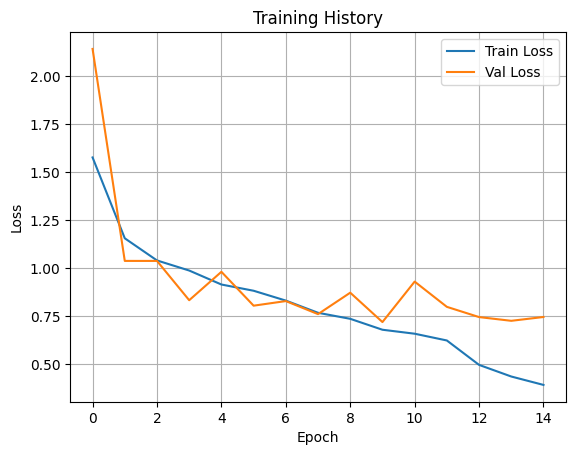

In [93]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.savefig("training_history.png")
plt.show()


## Dummy Classifier

In [94]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Flatten für sklearn-kompatibles Format
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

strategies = ['most_frequent', 'stratified', 'uniform']

for strategy in strategies:
    print(f"\nDummy Classifier – Strategy: {strategy}")
    dummy = DummyClassifier(strategy=strategy, random_state=42)
    dummy.fit(X_train_flat, y_train)
    y_pred = dummy.predict(X_test_flat)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2%}")
    print(classification_report(y_test, y_pred))



Dummy Classifier – Strategy: most_frequent
Accuracy: 43.18%
              precision    recall  f1-score   support

           0       0.43      1.00      0.60      3071
           1       0.00      0.00      0.00      1346
           2       0.00      0.00      0.00      1021
           3       0.00      0.00      0.00      1170
           4       0.00      0.00      0.00       504

    accuracy                           0.43      7112
   macro avg       0.09      0.20      0.12      7112
weighted avg       0.19      0.43      0.26      7112


Dummy Classifier – Strategy: stratified
Accuracy: 27.59%
              precision    recall  f1-score   support

           0       0.44      0.42      0.43      3071
           1       0.19      0.19      0.19      1346
           2       0.16      0.16      0.16      1021
           3       0.16      0.18      0.17      1170
           4       0.08      0.08      0.08       504

    accuracy                           0.28      7112
   macro avg

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Anhang

In [82]:
model.save("ethnicity_model.h5")


In [83]:
model.save('my_model.keras')

In [85]:
import pandas as pd

# history ist das Rückgabeobjekt von model.fit(...)
df_history = pd.DataFrame(history.history)
df_history.to_csv("training_history.csv", index=False)

